## Setup

In [ ]:
# Imports

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

In [ ]:
plt.style.use('seaborn-whitegrid')

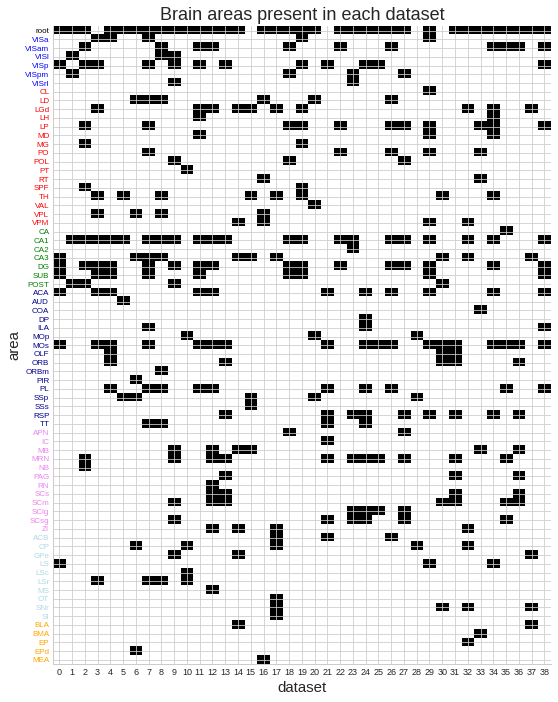

In [ ]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

## Define RNN

In [ ]:
# Params

np.random.seed(2020)

ncomp = 15
NT = 250

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x): 

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [ ]:
selected_session = 30
dat = alldat[selected_session]
dt = dat['bin_size']
x = dat['spks']
NN = x.shape[0]
NT = x.shape[1]
print(f'There are {NN} neurons in this session')
print(f'There are {NT} trials in this session')

There are 977 neurons in this session
There are 237 trials in this session


In [ ]:
np.unique(x)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

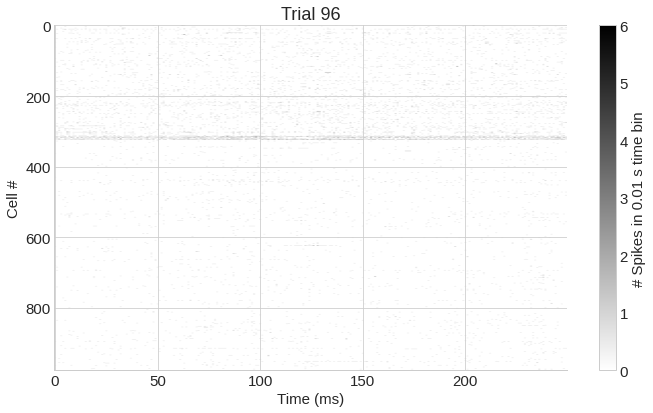

In [ ]:
num_trial = np.random.randint(0, NT)
plt.figure(figsize = (10, 6))
plt.imshow(x[:, num_trial, :], cmap='gray_r', vmax = 6, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title(f'Trial {num_trial}')
plt.show()

In [ ]:
a = np.unique(dat['brain_area'])
print(f'Available brain areas in this session: {a}')

Available brain areas in this session: ['CA3' 'MOs' 'OLF' 'ORB' 'POST' 'SCm' 'SNr' 'TH']


In [ ]:
selected_area = 'MOs'

input_neurons  = dat['spks'][dat['brain_area'] != selected_area]
output_neurons = dat['spks'][dat['brain_area'] == selected_area]

print(f'There are {input_neurons.shape[0]} input neurons')
print(f'There are {output_neurons.shape[0]} output neurons')

There are 696 input neurons
There are 281 output neurons


In [ ]:
# Generate train and test data
percent_train = 0.8
num_trial = output_neurons.shape[1]
idx = np.random.choice(np.arange(num_trial), num_trial, replace=False)
idx_train = idx[: int(percent_train * num_trial)]
idx_test = idx[int(percent_train * num_trial): ]
x_train = input_neurons[:, idx_train, :]
y_train = output_neurons[:, idx_train, :]

x_test = input_neurons[:, idx_test, :]
y_test = output_neurons[:, idx_test, :]

x_train = np.swapaxes(x_train, 0, 2)
y_train = np.swapaxes(y_train, 0, 2)
x_test = np.swapaxes(x_test, 0, 2)
y_test = np.swapaxes(y_test, 0, 2)

print(f'Shape of train data; input:{x_train.shape}, output:{y_train.shape}')
print(f'Shape of test data; input:{x_test.shape}, output:{y_test.shape}')

Shape of train data; input:(250, 189, 696), output:(250, 189, 281)
Shape of test data; input:(250, 48, 696), output:(250, 48, 281)


In [ ]:
input_population = torch.from_numpy(x_train).to(device).float() # VISam
output_population = torch.from_numpy(y_train).to(device).float() # other
NN1 = input_population.shape[-1]
NN2 = output_population.shape[-1]
print(NN1, NN2)
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = input_population.mean()

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

696 281


In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(input_population)

  # our log-likelihood cost
  cost = Poisson_loss(z, output_population).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.1821
iteration 100, cost 0.0768
iteration 200, cost 0.0741
iteration 300, cost 0.0733
iteration 400, cost 0.0728
iteration 500, cost 0.0724
iteration 600, cost 0.0720
iteration 700, cost 0.0717
iteration 800, cost 0.0715
iteration 900, cost 0.0713


In [ ]:
# Test
input_population_test = torch.from_numpy(x_test).to(device).float() 
output_population_test = torch.from_numpy(y_test).to(device).float()
z_test, q_test = net(input_population_test)
print(z_test.shape, q_test.shape)

torch.Size([250, 48, 281]) torch.Size([250, 48, 15])


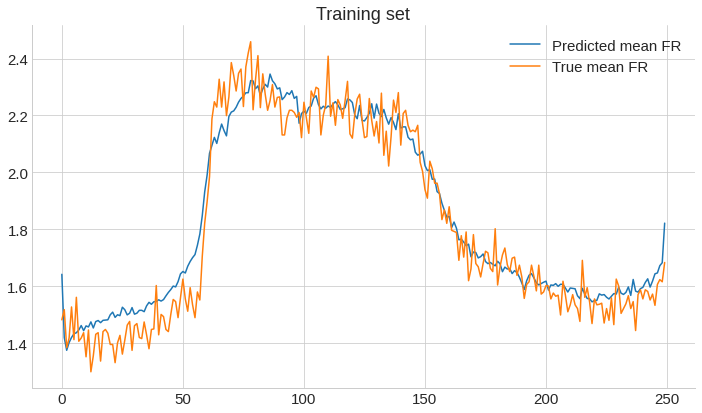

Cost on training set: 0.07135644555091858


In [ ]:
# Training set; avg across  all trials and neurons
rpred = z.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_train.mean(axis=(1, 2))
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.title('Training set')
plt.legend(['Predicted mean FR', 'True mean FR'])
plt.show()
cost_train = Poisson_loss(z, output_population).mean()
print(f'Cost on training set: {cost_train}')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(1/dt * rpred_mean, title='Predicted mean FR')
fig.add_trace(1/dt * y_true_mean, title='True mean FR')

TypeError: ignored

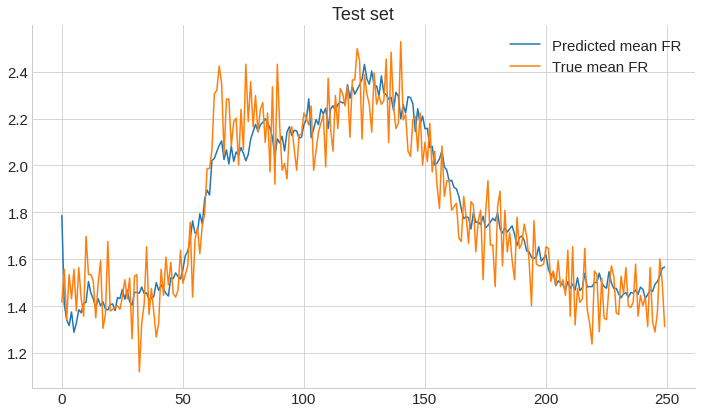

Cost on test set: 0.07484672218561172


In [ ]:
# Test set; avg across  all trials and neurons
rpred = z_test.detach().cpu().numpy()
rpred_mean = rpred.mean(axis=(1, 2))
y_true_mean = y_test.mean(axis=(1, 2))
plt.figure(figsize=(10, 6))
plt.plot(1/dt * rpred_mean)
plt.plot(1/dt * y_true_mean)
plt.legend(['Predicted mean FR', 'True mean FR'])
plt.title('Test set')
plt.show()
cost_test = Poisson_loss(z_test, output_population_test).mean()
print(f'Cost on test set: {cost_test}')

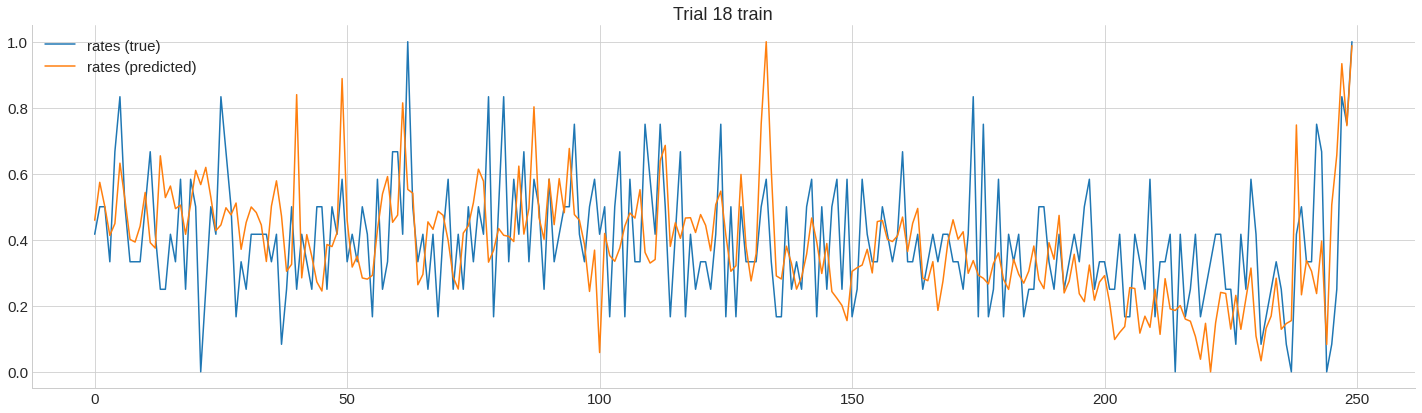

MSE cost = 0.03887303173542023


In [ ]:
# For each trial on training set
from sklearn import preprocessing
rpred = z.detach().cpu().numpy()
x0_true = output_population.detach().cpu().numpy()
# nn = 10
# xpred = np.random.poisson(rpred)

plt.figure(figsize=(20, 6))

#plt.plot(xpred[:, nn, 200])
#plt.plot(x[nn, 200, :])

trial = 18

a = x0_true.mean(axis=2)
a = a[:, trial]
a = (a - np.min(a)) / (np.max(a) - np.min(a)) # Normalization
plt.plot(a)

b = rpred.mean(axis=2)
b = b[:, trial]
b = (b - np.min(b)) / (np.max(b) - np.min(b)) # Normalization
plt.plot(b)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Trial {trial} train')
plt.show()

print(f'MSE cost = {np.mean((b - a)**2)}')

In [ ]:
# For each trial on test set
from sklearn import preprocessing
rpred = z_test.detach().cpu().numpy()
x0_true = output_population_test.detach().cpu().numpy()
# nn = 10
# xpred = np.random.poisson(rpred)

plt.figure(figsize=(20, 6))

#plt.plot(xpred[:, nn, 200])
#plt.plot(x[nn, 200, :])

trial = 18

a = x0_true.mean(axis=2)
a = a[:, trial]
a = (a - np.min(a)) / (np.max(a) - np.min(a)) # Normalization
plt.plot(a)

b = rpred.mean(axis=2)
b = b[:, trial]
b = (b - np.min(b)) / (np.max(b) - np.min(b)) # Normalization
plt.plot(b)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Trial {trial} test')
plt.show()

print(f'MSE cost = {np.mean((b - a)**2)}')

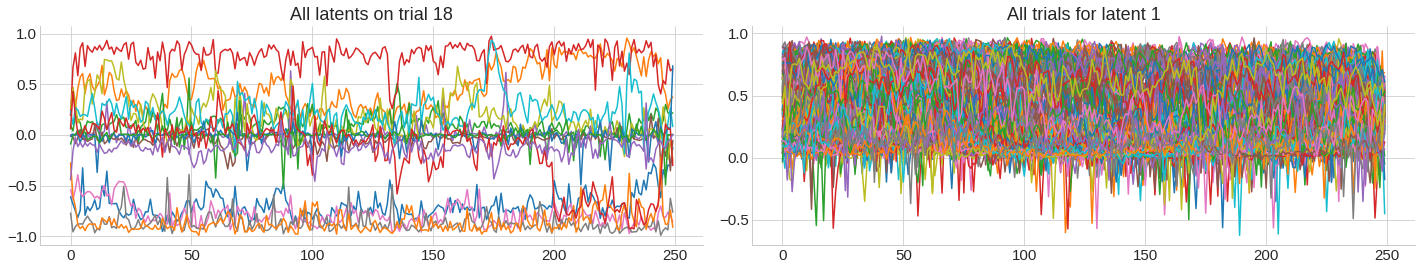

In [ ]:
ycpu = y.detach().cpu().numpy()

trial = 18
plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, trial, :]);
plt.title(f'All latents on trial {trial}')

latent = 1
plt.subplot(122)
plt.plot(ycpu[:, :, latent]);
plt.title(f'All trials for latent {latent}')
plt.show()

In [ ]:
latents = np.swapaxes(ycpu, 0, 1)
latents.shape

(189, 250, 15)

In [ ]:
import plotly.express as px
import pandas as pd
df = px.data.gapminder().query("country=='Brazil'")

x = latents[:,:,0]
y = latents[:,:,1]
z = latents[:,:,2]
wh = dat['response'][idx[: int(percent_train * num_trial)]]

df = pd.DataFrame({"x": x, "y":y, "z":z, 'col':wh})

fig = px.line_3d(df, x="x", y="y", z="z", color='col')
fig.show()

ValueError: ignored

In [ ]:
df_trial1 = pd.DataFrame

In [ ]:
import plotly.express as px
import pandas as pd
df = px.data.gapminder().query("country=='Brazil'")

x = latents[3,:,0]
y = latents[3,:,1]
z = latents[3,:,2]

df = pd.DataFrame({"x": x, "y":y, "z":z})





In [ ]:
df

## Wheel direction prediction with SVM

(189,)
(189, 250, 15)


(array([68.,  0.,  0.,  0.,  0., 62.,  0.,  0.,  0., 59.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

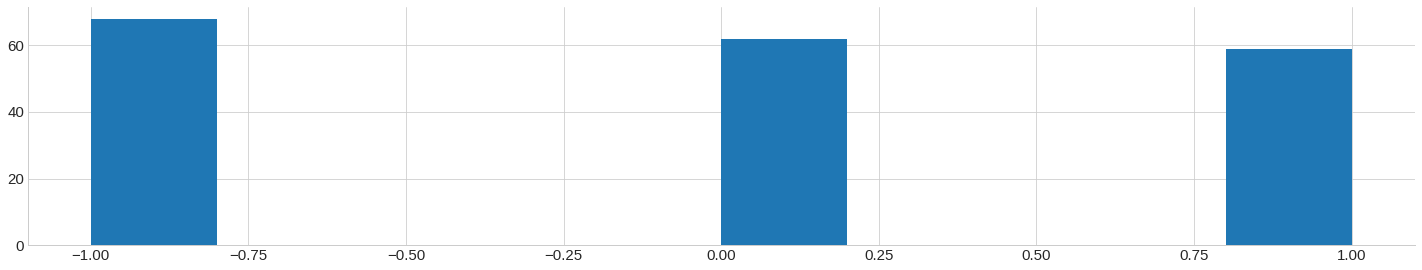

In [ ]:
wheel_direction = dat['response'][idx[: int(percent_train * num_trial)]]
print(wheel_direction.shape)
print(latents.shape)
plt.hist(wheel_direction)

In [ ]:
def SVMWheelDirection(latents, wheel_direction):

  wX_train, wX_test, wy_train, wy_test = train_test_split(latents, wheel_direction, test_size = 0.20)

  svclassifier = SVC(kernel='rbf')
  svclassifier.fit(wX_train, wy_train)

  wy_pred_train = svclassifier.predict(wX_train)
  wy_pred_test = svclassifier.predict(wX_test)

  acc_train = accuracy_score(wy_train, wy_pred_train)
  acc_test = accuracy_score(wy_test, wy_pred_test)

  return acc_train, acc_test

In [ ]:
latents = np.swapaxes(ycpu, 0, 1).reshape(ycpu.shape[1], ncomp*250)

In [ ]:
train_list = []
test_list = []

for i in range(250):

    latents_SVM = latents[:, i*10:(i+1)*10]
    a, b = SVMWheelDirection(latents_SVM, wheel_direction)

    train_list.append(a)
    test_list.append(b)


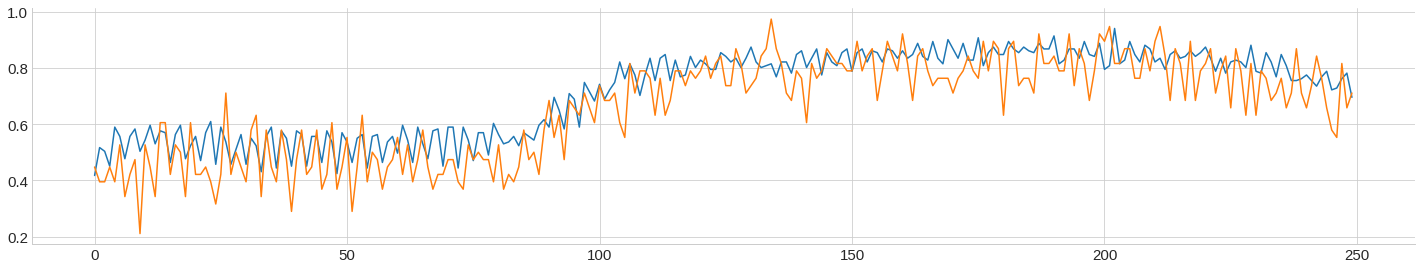

In [ ]:
plt.plot(train_list)
plt.plot(test_list)

In [ ]:
wX_train, wX_test, wy_train, wy_test = train_test_split(latents, wheel_direction, test_size = 0.20)

In [ ]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(wX_train, wy_train)

SVC()

In [ ]:
wy_pred_train = svclassifier.predict(wX_train)
print(confusion_matrix(wy_train, wy_pred_train))
print(classification_report(wy_train, wy_pred_train))

[[53  0  0]
 [ 0 49  0]
 [ 4  1 44]]
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96        53
         0.0       0.98      1.00      0.99        49
         1.0       1.00      0.90      0.95        49

    accuracy                           0.97       151
   macro avg       0.97      0.97      0.97       151
weighted avg       0.97      0.97      0.97       151



In [ ]:
wy_pred_test = svclassifier.predict(wX_test)
print(confusion_matrix(wy_test, wy_pred_test))
print(classification_report(wy_test, wy_pred_test))

[[14  0  1]
 [ 0 13  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

        -1.0       1.00      0.93      0.97        15
         0.0       0.93      1.00      0.96        13
         1.0       0.90      0.90      0.90        10

    accuracy                           0.95        38
   macro avg       0.94      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38



In [ ]:


accuracy_score(wy_train, wy_pred_train)

0.9668874172185431

In [ ]:
type(classification_report(wy_test, wy_pred_test))

str

## Regression from latents

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(250 * ncomp, 500),
      nn.ReLU(),
      nn.Linear(500, 500),
      nn.ReLU(),
      nn.Linear(500, 250)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [ ]:
  # Initialize the MLP
  mlp = MLP()
  mlp = mlp.to(device)
  # Define the loss function and optimizer
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4, weight_decay=1e-4)

In [ ]:
# train/test split
num_trial_mlp = ycpu.shape[1]
idx_mlp = np.random.choice(np.arange(num_trial_mlp), num_trial_mlp, replace=False)
idx_train_mlp = idx_mlp[: int(percent_train * num_trial_mlp)]
idx_test_mlp = idx_mlp[int(percent_train * num_trial_mlp): ]

ycpu_train = ycpu[:, idx_train_mlp, :]
ycpu_test = ycpu[:, idx_test_mlp, :]
wheel_speed_train = dat['wheel'][:, idx_train_mlp, :]
wheel_speed_test = dat['wheel'][:, idx_test_mlp, :]
print(ycpu_train.shape, ycpu_test.shape, wheel_speed_train.shape, 
      wheel_speed_test.shape)

(250, 151, 10) (250, 38, 10) (1, 151, 250) (1, 38, 250)


In [ ]:
latents_train = np.swapaxes(ycpu_train, 0, 1).reshape(idx_train_mlp.shape[0], 250*ncomp)
latents_test = np.swapaxes(ycpu_test, 0, 1).reshape(idx_test_mlp.shape[0], 250*ncomp)
print(latents_train.shape, latents_test.shape)

(151, 2500) (38, 2500)


In [ ]:
wheel_speed_train = np.swapaxes(wheel_speed_train, 0, 1).reshape(idx_train_mlp.shape[0], 250)
wheel_speed_test = np.swapaxes(wheel_speed_test, 0, 1).reshape(idx_test_mlp.shape[0], 250)
print(wheel_speed_train.shape, wheel_speed_test.shape)

(151, 250) (38, 250)


In [ ]:
latents_train_torch = torch.from_numpy(latents_train).to(device).float()
wheel_speed_train_torch = torch.from_numpy(wheel_speed_train).to(device).float()
wheel_speed_test_torch = torch.from_numpy(wheel_speed_test).to(device).float()

In [ ]:
num_iter = 500
for epoch in range(num_iter): 


  print(f'Starting epoch {epoch+1}')
  total_loss = 0.0

  for i in range(latents_train.shape[0]):
    
    
    inputs, targets = latents_train_torch[i, :], wheel_speed_train_torch[i, :]
    
    # inputs = torch.from_numpy(inputs).to(device).float()
    # targets = torch.from_numpy(targets).to(device).float()

    # targets = targets.reshape((targets.shape[0], 1))

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    total_loss += loss.item()
    # if i % 10 == 0:
    #     print('Loss after mini-batch %5d: %.3f' %
    #           (i + 1, current_loss / 500))
    #     current_loss = 0.0
  print(total_loss / (latents_train.shape[0]))
  total_loss = 0.0


# Process is complete.
print('Training process has finished.')

Starting epoch 1
32.9766198529905
Starting epoch 2
32.83504895077685
Starting epoch 3
32.668191902536826
Starting epoch 4
32.497158750965696
Starting epoch 5
32.422694693473694
Starting epoch 6
32.247109724708295
Starting epoch 7
32.05700596441694
Starting epoch 8
31.817564264482616
Starting epoch 9
31.53555293164111
Starting epoch 10
31.19628208318096
Starting epoch 11
30.890927645248293
Starting epoch 12
30.357090281742003
Starting epoch 13
29.851225208688454
Starting epoch 14
29.198680704422543
Starting epoch 15
28.42336750134135
Starting epoch 16
27.400492658826295
Starting epoch 17
25.913604083242795
Starting epoch 18
24.258738732890578
Starting epoch 19
22.860142635095198
Starting epoch 20
21.56485822431694
Starting epoch 21
20.272205171403506
Starting epoch 22
18.781998728580824
Starting epoch 23
17.640766796884158
Starting epoch 24
16.823921175192524
Starting epoch 25
16.042749472011792
Starting epoch 26
15.414194533564396
Starting epoch 27
14.896752452613502
Starting epoch 28


In [ ]:
outputss_train = mlp(latents_train_torch)
cost_train_wheel = F.mse_loss(outputss_train, wheel_speed_train_torch) \
                              / outputss_train.shape[0]
print(f"Train_loss = {cost_train_wheel}")
latents_test_torch = torch.from_numpy(latents_test).to(device).float()
outputss_test = mlp(latents_test_torch)
cost_test_wheel = F.mse_loss(outputss_test, wheel_speed_test_torch) \
                              / outputss_test.shape[0]
print(f"Test_loss = {cost_test_wheel}")
latents_train.shape[0]

Train_loss = 0.002029221039265394
Test_loss = 1.0734256505966187


151

In [ ]:
71 in idx_train_mlp

True

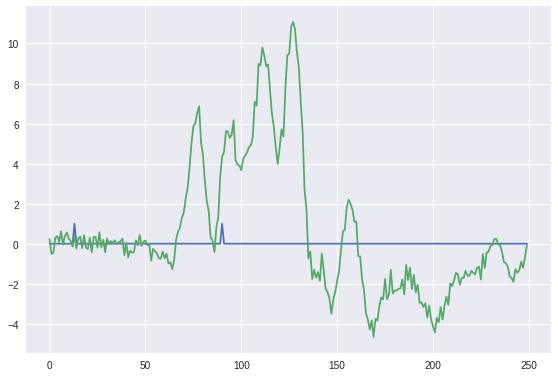

In [ ]:
outputsss_test = outputss_test.detach().cpu().numpy()
plt.plot(wheel_speed_test[12, :])
plt.plot(outputsss_test[12, :])

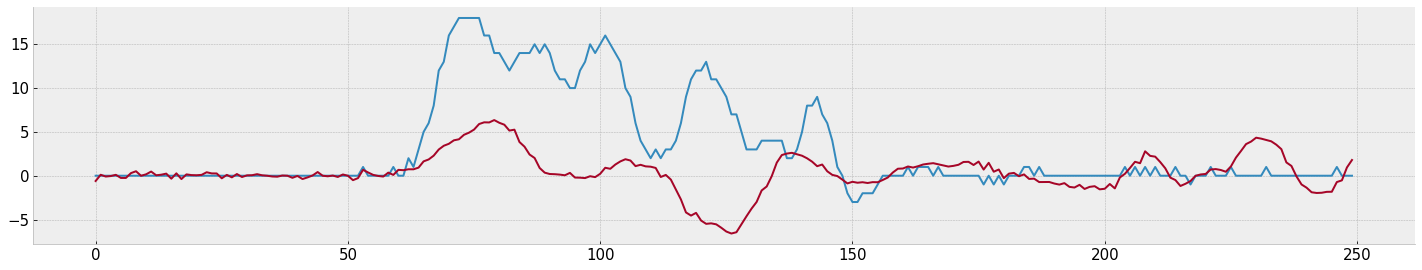

In [ ]:
outputss_test_cpu = outputss_test.detach().cpu().numpy()
plt.plot(wheel_speed_test[17, :])
plt.plot(outputss_test_cpu[17, :])

## RNN for latents -> Wheel speed

In [ ]:
# Remember somewhere above we've changed the shape of wheel_speed_train. DON'T run that.
wheel_speed_train_RNN = np.swapaxes(wheel_speed_train, 0, 2)
wheel_speed_test_RNN = np.swapaxes(wheel_speed_test, 0, 2)
print(wheel_speed_train_RNN.shape, wheel_speed_test_RNN.shape)
latents_train_RNN = ycpu_train
latents_test_RNN = ycpu_test
print(latents_train_RNN.shape, latents_test_RNN.shape)

(250, 151, 1) (250, 38, 1)
(250, 151, 10) (250, 38, 10)


In [ ]:
input_RNN_wheel = torch.from_numpy(latents_train_RNN).to(device).float()
output_RNN_wheel = torch.from_numpy(wheel_speed_train_RNN).to(device).float()
NN1 = input_RNN_wheel.shape[-1]
NN2 = output_RNN_wheel.shape[-1]
print(NN1, NN2)
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device) # net overrides previous net, RENAME!

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = input_population.mean() # net overrides previous net, RENAME!

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.05)

10 1


In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z_RNN, y_RNN = net(input_RNN_wheel)

  # our log-likelihood cost
  cost = loss_function(z_RNN, output_RNN_wheel).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 32.9511
iteration 100, cost 32.9511
iteration 200, cost 32.9511
iteration 300, cost 32.9511
iteration 400, cost 32.9511
iteration 500, cost 32.9511
iteration 600, cost 32.9511
iteration 700, cost 32.9511
iteration 800, cost 32.9511
iteration 900, cost 32.9511


In [ ]:
z_RNN

tensor([[[2.0219e-06],
         [5.4119e-06],
         [3.4111e-06],
         ...,
         [3.5388e-06],
         [1.0247e-05],
         [2.4520e-06]],

        [[3.5954e-07],
         [1.1873e-06],
         [2.7884e-07],
         ...,
         [5.8206e-07],
         [1.3208e-06],
         [3.6319e-07]],

        [[1.2359e-07],
         [5.1919e-07],
         [1.3218e-07],
         ...,
         [1.5254e-07],
         [4.0353e-07],
         [1.8359e-07]],

        ...,

        [[1.1378e-07],
         [1.4896e-07],
         [1.2640e-06],
         ...,
         [7.7981e-08],
         [1.0331e-07],
         [1.3011e-07]],

        [[1.6851e-07],
         [2.1317e-07],
         [1.6321e-06],
         ...,
         [1.7626e-07],
         [1.5994e-07],
         [2.4317e-07]],

        [[1.2609e-06],
         [8.7067e-07],
         [8.3838e-06],
         ...,
         [8.1837e-07],
         [1.7616e-06],
         [1.3772e-06]]], device='cuda:0', grad_fn=<SoftplusBackward0>)